In [1]:
import sympy as sm
import matplotlib.pyplot as plt
from pydy.viz import Sphere, Cylinder, VisualizationFrame, Scene
from scipy.integrate import solve_ivp
import numpy as np
import copy

from src.robotmodel import *

/home/guy/code/2d-robot-prognostics/.venv/lib/python3.8/site-packages/sympy/printing/ccode.py:8: SymPyDeprecationWarning: 

importing from sympy.printing.ccode has been deprecated since SymPy
1.7. Use Import from sympy.printing.c instead. See
https://github.com/sympy/sympy/issues/20256 for more info.

  SymPyDeprecationWarning(


# Constants

In [2]:
SIMULATION_TIME_STEP = 0.005

upper_arm_radius_constant = 0.054
upper_arm_mass_constant = 8.393
fore_arm_length_constant = 0.392
fore_arm_radius_constant = 0.060
fore_arm_mass_constant = 2.275

# https://github.com/ros-industrial/universal_robot/blob/kinetic-devel/ur_e_description/urdf/ur5e.urdf.xacro
model_constants = {
    upper_arm_length: 0.425,  # [m]
    upper_arm_com_length: 0.2125,  # [m]
    upper_arm_mass: upper_arm_mass_constant,  # [kg]
    upper_arm_inertia: 0.5 * upper_arm_mass_constant * upper_arm_radius_constant ** 2, # [kg*m^2]
    fore_arm_length: fore_arm_length_constant,  # [m]
    end_effector_mass: 0, # [kg]
    fore_arm_com_length: 0.11993,  # [m]
    fore_arm_mass: fore_arm_mass_constant,  # [kg]
    fore_arm_inertia: 0.5 * fore_arm_mass_constant * fore_arm_radius_constant ** 2, # [kg*m^2]
    shoulder_degradation: 0, # not actually a rate, viscous 
    elbow_degradation: 0,
    g: 0 #9.806
}

real_constants = copy.deepcopy(model_constants)

real_constants.update({
    shoulder_degradation: 1,
    elbow_degradation: 1,
    g: 9.806
})

model_sys = System(kane)
model_sys.constants = model_constants
model_sys.generate_ode_function()

real_sys = System(kane)
real_sys.constants = real_constants
real_sys.generate_ode_function()

<function pydy.codegen.ode_function_generators.ODEFunctionGenerator._create_rhs_function.<locals>.rhs(*args)>

# Setup

In [3]:
# Visualization
shoulder_shape = Cylinder(
    name='shoulder', color='grey', radius=0.06, length=0.13)
elbow_shape = Cylinder(name='elbow', color='grey', radius=0.06, length=0.13)

shoulder_viz_frame = VisualizationFrame(
    'shoulder', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), shoulder, shoulder_shape)
elbow_viz_frame = VisualizationFrame(
    'elbow', inertial_frame.orientnew('side', 'Axis', (pi/2, inertial_frame.x)), elbow, elbow_shape)

upper_arm_center = Point('l_c')
fore_arm_center = Point('u_c')

upper_arm_center.set_pos(
    shoulder, model_sys.constants[upper_arm_length]/2 * upper_arm_frame.y)
fore_arm_center.set_pos(elbow, fore_arm_length_constant/2 * fore_arm_frame.y)

upper_arm_shape = Cylinder(name='upper arm',
                           radius=upper_arm_radius_constant,
                           length=model_sys.constants[upper_arm_length],
                           color='lightskyblue')

fore_arm_shape = Cylinder(name='fore arm',
                          radius=fore_arm_radius_constant,
                          length=fore_arm_length_constant,
                          color='lightskyblue')

upper_arm_viz_frame = VisualizationFrame('Upper Arm', upper_arm_frame,
                                         upper_arm_center, upper_arm_shape)

fore_arm_viz_frame = VisualizationFrame('Fore Arm', fore_arm_frame,
                                        fore_arm_center, fore_arm_shape)

In [4]:
from src.controller import build_optimal_controller


equilibrium_point = np.zeros(len(coordinates + speeds))
equilibrium_dict = dict(zip(coordinates + speeds, equilibrium_point))

r = np.array([[1], [1]])  # two desired angles

K, Nbar = build_optimal_controller(kane, model_sys.constants, equilibrium_dict)

fore_arm_grav_compensator = sm.lambdify(
    [theta1, theta2], fore_arm_grav_compensation_expr.subs(real_sys.constants))
upper_arm_grav_compensator = sm.lambdify(
    [theta1, theta2], upper_arm_grav_compensation_expr.subs(real_sys.constants))

def controller(x, t):
    u = np.asarray(np.add(-np.matmul(K, x).reshape(2, 1),
                          np.matmul(Nbar, r).reshape(2, 1))).flatten()
    u[0] -= upper_arm_grav_compensator(x[0], x[1])
    u[1] -= fore_arm_grav_compensator(x[0], x[1])
    return u


# Single Movement

array([ 9.99943561e-01,  1.00162780e+00,  3.78557083e-05, -1.24262917e-03])

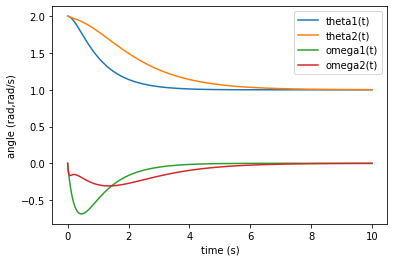

In [5]:
simulation_time = 10
times = np.arange(0.0, simulation_time, SIMULATION_TIME_STEP)

sol = solve_ivp(lambda x, t, r, p: real_sys.evaluate_ode_function(t, x, r, p),
                (times[0], times[-1]), [2, 2, 0, 0], method='LSODA', args=(controller, real_sys.constants))

plt.plot(sol.t, np.transpose(sol.y))
plt.legend(model_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')
sol.y[:, -1]

In [6]:
scene = Scene(inertial_frame, shoulder)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                              upper_arm_viz_frame, fore_arm_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = model_sys.constants
scene.states_trajectories = np.transpose(sol.y)
scene.times = sol.t
# scene.display_jupyter()

# Repeated Movement

array([ 9.99943561e-01,  1.00162780e+00,  3.78557083e-05, -1.24262917e-03])

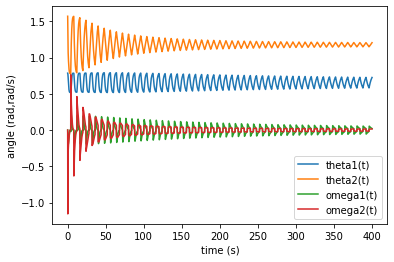

In [7]:
def full_simulation(chunks, chunk_time, desired_positions, shoulder_degradation_rate, elbow_degradation_rate):
    chunk_times = np.arange(0.0, chunk_time, SIMULATION_TIME_STEP)

    all_positions = np.tile(desired_positions, (1, chunks))

    chunk_initial_conditions = np.vstack(
        (desired_positions[:, -1].reshape(2,1), [[0], [0]]))  # and zero velocities

    all_t = np.empty((chunk_times.size * chunks, 1)) # times
    all_y = np.empty((chunk_times.size * chunks, 4))  # 4 states
    all_command = np.empty((chunk_times.size * chunks, 2)) # 2 inputs

    for i in range(chunks):
        r = all_positions[:, i]
        chunk_times = np.arange(chunk_time * i, chunk_time * (i+1), SIMULATION_TIME_STEP)
        output_indices = np.array([0, chunk_times.size]) + chunk_times.size * i

        # update model parameters
        real_constants[elbow_degradation] = i*elbow_degradation_rate  # Increase degradation each chunk
        real_constants[shoulder_degradation] = i*shoulder_degradation_rate # Increase degradation each chunk
        real_sys = System(kane) # make a new system (because it is required when changing constants)
        real_sys.constants = real_constants
        real_sys.generate_ode_function()

        def controller(x, t):
            u = np.asarray(np.add(-np.matmul(K, x).reshape(2, 1),
                                np.matmul(Nbar, r).reshape(2, 1))).flatten() # LQR Controller
            u[0] -= upper_arm_grav_compensator(x[0], x[1]) # Gravity Compensation
            u[1] -= fore_arm_grav_compensator(x[0], x[1]) # Gravity Compensation
            return u

        sol = solve_ivp(lambda x, t, r, p: real_sys.evaluate_ode_function(t, x, r, p),
                        (chunk_times[0], chunk_times[-1]), chunk_initial_conditions.flatten(), method='LSODA', t_eval=chunk_times, args=(controller, real_sys.constants))

        all_t[output_indices[0]:output_indices[1],:] = sol.t.reshape(sol.t.size,1)
        all_y[output_indices[0]:output_indices[1],:] = np.transpose(sol.y)
        
        commands = np.apply_along_axis(lambda a: controller(a,0), 1, np.transpose(sol.y))
        all_command[output_indices[0]:output_indices[1],:] = commands

        chunk_initial_conditions = sol.y[:, -1]

    return (all_t, all_y, all_command)


#######################

all_t, all_y, all_command = full_simulation(100, 4, np.deg2rad(np.array([[30, 45], [45, 90]])), 0.1, 0.2)

plt.plot(all_t, all_y)
plt.legend(model_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')
sol.y[:, -1]

#If this takes more than 10s, restart the kernel (help!)

array([ 9.99943561e-01,  1.00162780e+00,  3.78557083e-05, -1.24262917e-03])

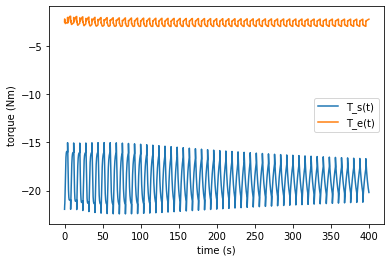

In [8]:
plt.plot(all_t, all_command)
plt.legend(model_sys.specifieds_symbols)
plt.xlabel('time (s)')
plt.ylabel('torque (Nm)')
sol.y[:, -1]

array([ 9.99943561e-01,  1.00162780e+00,  3.78557083e-05, -1.24262917e-03])

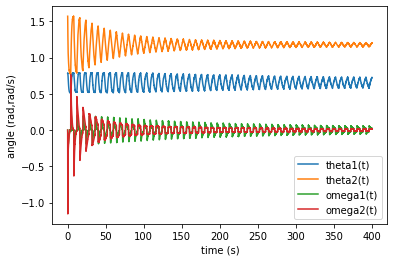

In [9]:
signal_range = np.min(np.ptp(all_y[:,:2], axis=0))
random_addition = np.random.normal(0,signal_range/1000, all_y.shape)
noise_y = all_y + random_addition

plt.plot(all_t, noise_y)
plt.legend(model_sys.states)
plt.xlabel('time (s)')
plt.ylabel('angle (rad,rad/s)')
sol.y[:, -1]

In [10]:
scene = Scene(inertial_frame, shoulder)

scene.visualization_frames = [shoulder_viz_frame, elbow_viz_frame,
                              upper_arm_viz_frame, fore_arm_viz_frame]

scene.states_symbols = coordinates + speeds
scene.constants = model_sys.constants
scene.states_trajectories = all_y
scene.times = all_t
# scene.display_jupyter()

In [13]:
elbow_degradations = [0.1, 0.4, 0.9]
shoulder_degradations = [0.1, 0.4, 0.9]

for elbow_deg in elbow_degradations:
    for shoulder_deg in shoulder_degradations:
        all_t, all_y, all_command = full_simulation(100, 4, np.deg2rad(np.array([[30, 45], [45, 90]])), shoulder_deg, elbow_deg)
        
        signal_range = np.min(np.ptp(all_y[:,:2], axis=0))
        random_addition = np.random.normal(0,signal_range/1000, all_y.shape)
        noise_y = all_y + random_addition

        np.savetxt("shoulder{:d}-elbow{:d}.csv".format(int(shoulder_deg*100),int(elbow_deg*100)),np.hstack((all_t, all_y, all_command)), fmt='%2.5f')

with open("header.txt", "w") as text_file:
    text_file.write("time\ttheta1\ttheta2\tomega1\tomega2\ttorque1\ttorque2")